<a href="https://colab.research.google.com/github/joseortegalabra/MLBI/blob/master/DCGAN_%26_Prediction_Stocks_prices(RNN)_(C2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Certamen 2: Machine Learning for Business Intelligence.

## Instrucciones

1. Este certamen es de caracter individual, por lo tanto queda estrictamente prohibida la copia de codigo ajeno. **Cualquier copia será motivo de reprobación (esto excluye código mostrado en laboratorios prácticos).**

2. En caso de elaborar su respuesta **basandose** en código ajeno encontrado en la web, debe agradecer al menos citando la referencia.

3. La fecha límite para la entrega de este certamen queda establecida para el **22/08/2020 a la media noche**.

Nota: La resolución de algunos de los ejercicios puede tomar bastante tiempo, así como su ejecución. Por lo tanto se recomienda hacer la tarea con anticipación y evitar riesgos. Además, es **obligatorio el uso de Google Colab**.

## Pregunta 1: Convolutional Generative Adversarial Nets (CGAN).

En esta sección, se pide reproducir el modelo [Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets) (Goodfellow I., et al. 2014), utilizando redes convolucionales. Para esto se utilizará el dataset Fashion MNIST, que consiste en prendas de ropa en blanco y negro.


1.1 Cargue los datos utilizando la ayuda de su [https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data](documentación). Muestre al menos 1 imagen de cada clase, pertenecientes al conjunto de entrenamiento (2 ptos). 

1.2 En clases se vieron ciertas técnicas para mejorar el entrenamiento de los modelos generativos adversarios [(ref)](https://arxiv.org/abs/1606.03498). Dentro de ellas estaba la normalización de los datos entre [-1,1]. Normalice el conjunto de entrenamiento entre ese rango. Además, añada una dimensión extra que permita el uso de redes convolucionales 2D (como se vio en clases) (3 ptos).

1.3 Construya una arquitectura convolucional que permita el entrenamiento del modelo (generador y discriminador), siguiendo los consejos vistos en clases (ej. batch normalization, leaky relu). Para este paso, es posible utilizar como base la arquitectura encoder-decoder vista en clase práctica (sin embargo, debe tener en cuenta que esa arquitectura recibe como input una imagen de (1, 32, 32), por lo cual sería necesario redimensionar las imágenes del conjunto de entrenamiento previamente) (5 ptos).

1.4 Entrene el modelo generativo adversario utilizando optimizador Adam y los siguientes hiperparámetros (5 ptos):
- learning_rate=0.0002
- beta_1=0.5
- latent_dim=100
- num_epochs=1000.

1.5 Muestre imágenes generadas en la epoca 10, 100, 500 y 1000 (5 ptos).

In [ ]:
from keras.datasets.fashion_mnist import load_data
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
from keras.models import Model
from keras.layers import Dense, BatchNormalization, LeakyReLU, Conv2DTranspose, Conv2D, Dropout, Flatten, Reshape, Input, Lambda, Concatenate
from google.colab import drive
from google.colab import files
import pandas as pd
drive.mount('/content/drive')
from keras.layers import LSTM, Dropout, Dense
from keras.models import Sequential

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
class fashion():
  def __init__(self):
    (self.X_train, self.y_train), (_, _) = load_data()  #crear datos

  def dimensions(self):
    print('Dimensions Set Train')
    print('Dimensions X_train', self.X_train.shape)
    print('Dimensions y_train', self.y_train.shape)
    
  def expand_pixels_data(self):    #no se deberia usar de expandir pixeles
    data_train_resized = []
    for i in range(self.X_train.shape[0]):
      data_train_resized.append(cv2.resize(self.X_train[i, :, :], dsize=(32, 32), interpolation=cv2.INTER_CUBIC))
    self.X_train = np.array(data_train_resized)
  
  def expand_dim_data(self):
    self.X_train = np.expand_dims(self.X_train, axis = 3)

  def normalize(self):
    self.X_train = (self.X_train - 127.5) / 127.5  
    print('done [-1,1]!\nExample first image')
    print('Max value',self.X_train[0,:,:,:].max() )
    print('Min value', self.X_train[0,:,:,:].min(), '\n')

  def create_random_matrix(self):
    classes = np.unique(self.y_train).tolist()
    random_matrix = []
    labels_random_matrix = []
    i = 0
    while i<len(np.unique(self.y_train)):
      random_index = np.random.randint(0, self.X_train.shape[0])
      if self.y_train[random_index] in classes:
        classes.remove(self.y_train[random_index])
        random_matrix.append(random_index)
        labels_random_matrix.append(self.y_train[random_index])
        i+=1
    return np.array(random_matrix), np.array(labels_random_matrix)

  def visual_examples(self):
    num_rows = 5
    num_columns = 2
    #dejar las imagenes en la dimensión (n, 32, 32) quitar una dimensión
    data = np.squeeze(self.X_train)
    #funcion solo para imagenes de la forma (x,y)  2 dimensiones
    fig, axs = plt.subplots(num_rows,num_columns, figsize=(10,10))
    random_index , random_labels = self.create_random_matrix()
    random_index , random_labels = random_index.reshape((num_rows, num_columns)), random_labels.reshape((num_rows, num_columns))
    fig.suptitle('Examples', fontsize=16)
    for i in range(num_rows):
        for j in range(num_columns):
            axs[i,j].imshow(data[random_index[i][j], :,:], cmap='gray')
            axs[i,j].set_title('Class: [' + str( random_labels[i][j] )  + ']') 
            axs[i,j].xaxis.set_visible(False)
            axs[i,j].yaxis.set_visible(False)
    plt.show()

In [ ]:
data_gan = fashion()
data_gan.dimensions()

4423680/4422102 [==============================] - 0s 0us/step
Dimensions Set Train
Dimensions X_train (60000, 28, 28)
Dimensions y_train (60000,)


In [ ]:
#Redimencionar dimensiones a 32x32 
#X_train = data_gan.expand_pixels_data()  
#data_gan.dimensions()
#USO UNA ESTRUCTURA 28X28

In [ ]:
#Expandir las dimensiones
data_gan.expand_dim_data()
data_gan.dimensions()

Dimensions Set Train
Dimensions X_train (60000, 28, 28, 1)
Dimensions y_train (60000,)


In [ ]:
#normalizar datos -1 a 1
data_gan.normalize()
data_gan.dimensions()

done [-1,1]!
Example first image
Max value 1.0
Min value -1.0 

Dimensions Set Train
Dimensions X_train (60000, 28, 28, 1)
Dimensions y_train (60000,)


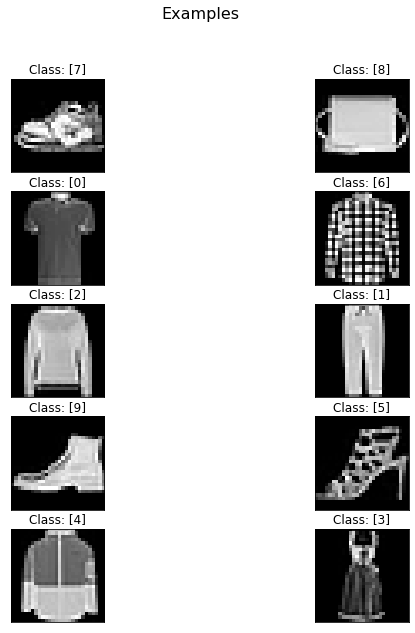

In [ ]:
data_gan.visual_examples()

In [ ]:
X_train, y_train = data_gan.X_train, data_gan.y_train  #con un metodo que lo asigne se podria ver más ordenado

### DCGAN model
Adaptado de: https://www.tensorflow.org/tutorials/generative/dcgan

In [ ]:
#HIPERPARMETROS
buffer_size = X_train.shape[0]  #cantidad de datos
batch_size = 256  
epochs = 1000
noise_dim = 100

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)     #cross_entropy(imagen_real, imagen_predicha)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [ ]:
#dataset de tf
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [ ]:
def make_generator_dcgan():
  #created in base: https://www.tensorflow.org/tutorials/generative/dcgan
  
  model = tf.keras.Sequential(name = 'generator')

  #PADDING SAME definition in CONV2D layer
  #out_dimension = ceil(dimension / stride)
  
  #first layers fully conected
  #salida es una capa de tamaño 7x7x256 neuronas y la entrada es una capa de 100 neuronas - espacio latente
  model.add(Dense(7*7*128, use_bias = False, input_shape = (100,) )  )   #shape: 12544     #original 256
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  #Second layer reshape
  #reordeno las neuronas de la capa fully contected para que tenga formato de imagen - lo contrario a un flattten
  model.add(Reshape((7, 7, 128)))    #shape   7x7x256    image       #original 256

  #Third layer CONV2DT
  #Una capa de deconvolusión con salida 128 canales, filtro de (5,5) con stride de 1, padding = relleno para conservar las dimensiones iniciales
  model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))  #shape 7x7x128     #original 128
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  #Fourth layer CONV2DT
  #capa deconvlusión con 64 canales (filtros) con stride 2 que multiplica las dimensiones al ser una deconvolusion
  model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))   #shape 14x14x64      #original 64
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  #Fitfth layerCON2DT
  #capa deconvolusión con 1 filtro y que me genera una imagen de 28x28x1 que es el tamaño original
  model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))   #shape 28x28x1

  return model

def make_discriminator_dcgan():
    model = tf.keras.Sequential(name = 'discriminator')
    
    #Firts layer CONV2D
    #conv2d   64 canales, filter = (5x5), stride =2 , tamaño de entrada 28x28x1, padding same divido las dimensiones
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))   #shape = 14x14x64
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    #Second layer CONV2D
    #segunda capa conv2d   128 canales, filtro = (5x5), stride = 2
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))  #shape = 7x7x128  #original 128
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    #Third layer Flatten and Fully Connected with 1 neuron 
    #Valor de salida es positivo para una imagen real y negativo para una ficticia
    model.add(Flatten())  #shape = 7x7x178 = 6272 neurons
    model.add(Dense(1)) #shape = 1

    return model

def discriminator_loss_dcgan(real_output, fake_output):     #salida por el discriminador de la imagen real, salida por el discriminador de la imagen ficticia
    '''
    Pasar por el discriminador evalua una imagen y da un valor 1 si cree que es una imagen real y un cero si cree que es ficticia.
    Si discrimina bien para la imagen ficticia le va a dar un valor 0 y la loss es baja. 
    Si discrimina bien para la imagen real le va a dar un valor de 1 y la loss es baja.
    '''
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)   #real_loss (vector de 1, salida por el discriminador de la imagen real)        
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) #fake_loss (vector de 0, salida por el discriminador de la imagen ficticia)
    total_loss = real_loss + fake_loss   #loss total es la suma de la diferencia entre las imagenes reales con un 1 y las ficticias con cero
    return total_loss

def generator_loss_dcgan(fake_output):      #por el generador solo pasa la imagen ficticia 
    '''
    Por el generador se evalua la imagen ficticia (ruido).
    Si el discriminador es engañado va a evaluar la imagen ficticia con un valor de 1, entonces en el generador se compara el output por el 
    discriminador de la imagen ficticia con respecto a un 1 y al optimizar va a querer que la loss baje y por lo tanto el generador trata de crear
    imagenes ficticias que el discriminador piense que son reales.
    '''
    return cross_entropy(tf.ones_like(fake_output), fake_output)     #loss (vector de 1, salida del driscriminador de la imagen ficticia)

def train_step_dcgan(images, size_batch, size_noise, model_g, model_d):  #(tamaño batch, 28, 28, 1)
    noise = tf.random.normal([size_batch, size_noise])      

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = model_g(noise, training=True)
      real_output = model_d(images, training=True)
      fake_output = model_d(generated_images, training=True)

      gen_loss = generator_loss_dcgan(fake_output)
      disc_loss = discriminator_loss_dcgan(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, model_g.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, model_d.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, model_g.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, model_d.trainable_variables))

def generate_images_dcgan(model, test_input):
  predictions = model(test_input, training=False)
  #crear 3x3 resultados
  fig = plt.figure(figsize=(10,10))
  for i in range(predictions.shape[0]):
      plt.subplot(3, 3, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.show()
  return predictions #retornar valores

def train_dcgan(dataset, num_epochs, size_batch, size_noise, model_g, model_d):
  list_test = []
  for epoch in range(num_epochs):
    if (epoch + 1) % 30 == 0:   #display de avance
      print('Num epoch:', epoch+1)
    
    for image_batch in dataset:  #entrenar
      train_step_dcgan(image_batch, size_batch, size_noise, model_g, model_d) 

    if (epoch == 9 or epoch == 99 or epoch == 499 or epoch == 999):  #generar datos en la epoca 10,100,500 y 1000
      print('EXAMPLES EPOCH: ', epoch+1)
      list_test.append(   generate_images_dcgan(model_g, tf.random.normal([9, size_noise]))  )  #generar 9 imagenes sin entrenar el modelo 
  return list_test

In [ ]:
generator_dcgan = make_generator_dcgan()
generator_dcgan.summary()
#tf.keras.utils.plot_model(generator_dcgan, show_shapes=True, dpi=50)

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              627200    
_________________________________________________________________
batch_normalization (BatchNo (None, 6272)              25088     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         409600    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0 

In [ ]:
discriminator_dcgan = make_discriminator_dcgan()
discriminator_dcgan.summary()
#tf.keras.utils.plot_model(discriminator_dcgan, show_shapes=True, dpi=50)

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)            

EXAMPLES EPOCH:  10


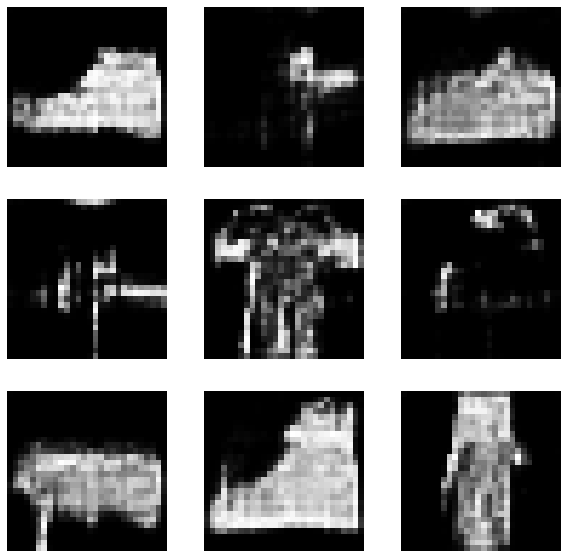

Num epoch: 30
Num epoch: 60
Num epoch: 90
EXAMPLES EPOCH:  100


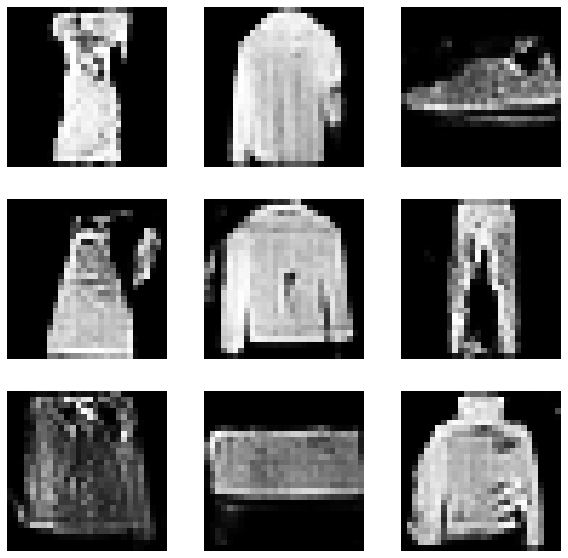

Num epoch: 120
Num epoch: 150
Num epoch: 180
Num epoch: 210
Num epoch: 240
Num epoch: 270
Num epoch: 300
Num epoch: 330
Num epoch: 360
Num epoch: 390
Num epoch: 420
Num epoch: 450
Num epoch: 480
EXAMPLES EPOCH:  500


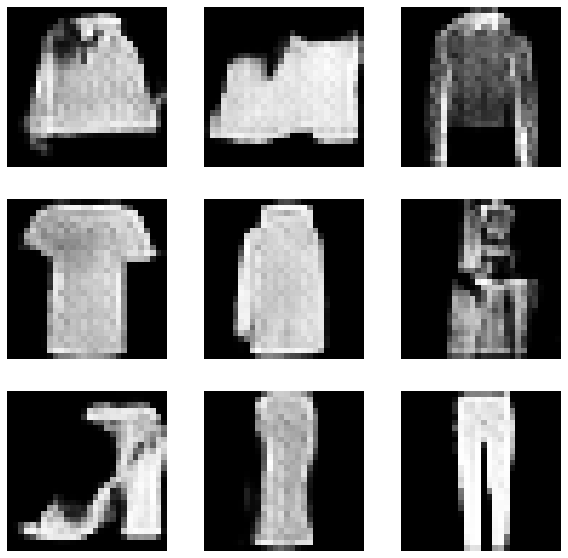

Num epoch: 510
Num epoch: 540
Num epoch: 570
Num epoch: 600
Num epoch: 630
Num epoch: 660
Num epoch: 690
Num epoch: 720
Num epoch: 750
Num epoch: 780
Num epoch: 810
Num epoch: 840
Num epoch: 870
Num epoch: 900
Num epoch: 930
Num epoch: 960
Num epoch: 990
EXAMPLES EPOCH:  1000


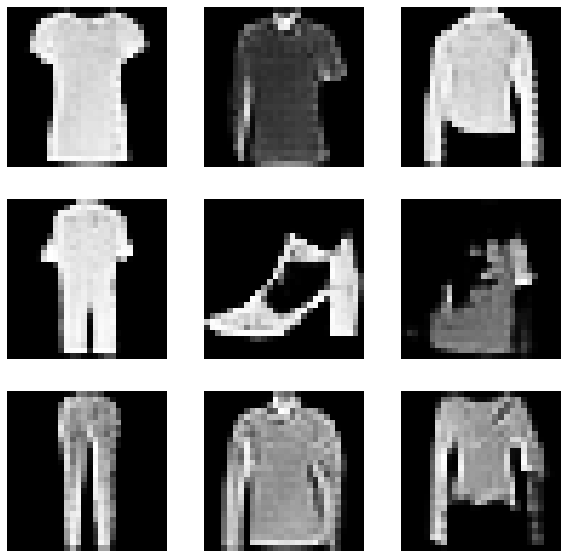

In [ ]:
#ENTRENAR GAN
history_dcgan = train_dcgan(dataset= train_dataset,
                  num_epochs= epochs,
                  size_batch= batch_size,
                  size_noise = noise_dim,
                  model_g = generator_dcgan,
                  model_d = discriminator_dcgan)

In [ ]:
#guardar valores de ejemplos
np.save('Results DCGAN small', history_dcgan)

In [ ]:
#save model
generator_dcgan.save('model_generator_dcgan.h5')
discriminator_dcgan.save('model_discriminator_dcgan.h5')

In [ ]:
#save weights
generator_dcgan.save_weights('generator_dcgan_weights.h5')
discriminator_dcgan.save_weights('discriminator_dcgan_weights.h5')

### GAN (Fully Connected - 1d)
Se emplea una estructura más sencilla(vista en clases) para comparar a los resultados obtenidos por la DCGAN

In [ ]:
def create_encoder_generador_gan(shape_noise, shape_encoder_latent):
  #layer input 
  z = Input(shape=(shape_noise,))    #shape = 100
  #First layer Fully-Connected
  x_gen = Dense(n_hidden_neurons)(z)    #shape = 256
  x_gen = LeakyReLU(alpha=0.2)(x_gen)
  x_gen = BatchNormalization(momentum=0.8)(x_gen)
  
  #Second layer Fully-Connected
  x_gen = Dense(n_hidden_neurons*2)(x_gen)   #shape = 512
  x_gen = LeakyReLU(alpha=0.2)(x_gen)
  x_gen = BatchNormalization(momentum=0.8)(x_gen)

  #Third layer Fully-connected
  x_gen = Dense(n_hidden_neurons*4)(x_gen)   #shape = 1024
  x_gen = LeakyReLU(alpha=0.2)(x_gen)
  x_gen = BatchNormalization(momentum=0.8)(x_gen)

  #Fourth layer Fully-connected
  x_hat = Dense(shape_encoder_latent, activation='tanh')(x_gen)   #shape = 28*28 = 784: tamaño de la imagen

  return Model(z, x_hat, name = 'encoder_generator_gan')


def create_decoder_discriminator_gan(shape_encoder_latent):
  #layer input
  x = Input(shape=( shape_encoder_latent,)  )   #shape = 28*28 = 784: tamaño de la imagen
  
  #First layer Fully-Connected
  x_disc = Dense(n_hidden_neurons*2)(x)   #shape = 512
  x_disc = LeakyReLU(alpha=0.2)(x_disc)
  
  #Second layer Fully-Connected
  x_disc = Dense(n_hidden_neurons)(x_disc)   #shape = 256
  x_disc = LeakyReLU(alpha=0.2)(x_disc)

  #Third layer Fully-Connected
  y_hat = Dense(1, activation='sigmoid')(x_disc)   #shape = 1  #clasification real or fake

  return Model(x, y_hat, name = 'decoder_discriminator_gan')

def create_encoder_decoder_gan(shape_noise, model_encoder, model_decoder):   
  '''
  Crear el modelo generador, paso por el generador y luego por el discriminador, este ultimo no se entrena
  '''
  z = Input(shape=( shape_noise,)  )   #shape = 100
  fake_img = model_encoder(z)     #creo imagen falsa
  model_decoder.trainable = False     #Para generar imagenes falsas el discriminador no se entrena, solo el generador - encoder
  fake_pred = model_decoder(fake_img)  #hago pasar la imagen falsa por el discriminador
  combined = Model(z, fake_pred, name = 'Encoder-Decoder_to_generate_false_image')  #obtengo un modelo encoder-decoder  // generador-discriminador
  return combined

def generate_images_test_gan(model_encounder, latent_dim):
  row, col = 3,3
  noise = np.random.normal(0, 1, (row * col, latent_dim))
  gen_imgs = model_encounder.predict(noise)

  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5
  
  return gen_imgs

def train_gan(generator, discriminator, combined,  batch, n_epochs, latent_dim, x_train):
  true_labels = np.ones((batch, 1))
  fake_labels = np.zeros((batch, 1))
  gen_losses = []
  disc_losses = []
  list_test = []

  for epoch in range(n_epochs):
    #Select some real images from the dataset
    idx = np.random.randint(0, x_train.shape[0], batch)
    imgs = x_train[idx]
    
    #DISCRIMINADOR
    noise = np.random.normal(0, 1, (batch, latent_dim))  #generar ruido del tamaño del batch
    fake_imgs = generator.predict(noise)  #pasar ruido por el encoder (100-784) y generar imagen falsa
    d_loss_real = discriminator.train_on_batch(imgs, true_labels)  #entrenar discriminador (imagenes reales, 1)
    d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_labels) #entrenar discriminador (imagen falsa , 0)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  #loss del discriminador ponderada que clasifique bien
    
    #GENERADOR
    noise = np.random.normal(0, 1, (batch, latent_dim))  #generar ruido del tamaño del batch - no deberia ser el mismo de arriba?
    g_loss = combined.train_on_batch(noise, true_labels) #entrenar generador y que pase por el discriminador sin entrenar (imagen falsa, 1)
    
    #show results
    if (epoch == 9 or epoch == 99 or epoch == 499 or epoch == 999):  #generar datos en la epoca 10,100,500 y 1000
      print('Num epoch:', epoch+1, 'generated image')
      list_test.append(  generate_images_test_gan(generator, latent_dim) )

  return list_test

In [ ]:
#adaptar los datos para GAN - una sola columna de datos - flatten
X_train_gan = X_train.reshape(X_train.shape[0], -1)
X_train_gan.shape

(60000, 784)

In [ ]:
#hyperparameters GAN
epochs = 1000
n_hidden_neurons = 256
noise_dim = 100

batch_size = 256

adam = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)   #configuracion del optimizador

In [ ]:
encoder_generator_gan = create_encoder_generador_gan(noise_dim, X_train_gan.shape[1])  #tamaño del ruido, tamaño de las imagenes 
encoder_generator_gan.summary()

Model: "encoder_generator_gan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
dense_15 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)     

In [ ]:
decoder_discriminator_gan = create_decoder_discriminator_gan(X_train_gan.shape[1]) #tamaño de las imagenes
decoder_discriminator_gan.compile(optimizer=adam, loss='binary_crossentropy')
decoder_discriminator_gan.summary()

Model: "decoder_discriminator_gan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
___________________________________

In [ ]:
encoder_decoder_gan = create_encoder_decoder_gan( noise_dim, encoder_generator_gan, decoder_discriminator_gan) 
encoder_decoder_gan.compile(optimizer=adam, loss='binary_crossentropy')  
encoder_decoder_gan.summary()

Model: "Encoder-Decoder_to_generate_false_image"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
encoder_generator_gan (Funct (None, 784)               1493520   
_________________________________________________________________
decoder_discriminator_gan (F (None, 1)                 533505    
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


In [ ]:
history_gan = train_gan(generator= encoder_generator_gan,
                        discriminator= decoder_discriminator_gan,
                        combined = encoder_decoder_gan,
                        batch = batch_size,
                        n_epochs = epochs,
                        latent_dim = noise_dim,
                        x_train = X_train_gan
                        )

Num epoch: 10 generated image
Num epoch: 100 generated image
Num epoch: 500 generated image
Num epoch: 1000 generated image


In [ ]:
#history_dcgan = np.load('/content/Results DCGAN small.npy')

### Comparation between DCGAN y GAN
Se comparan ambos modelos que se modelaron con los mismos hiperparametros pero con la estructura distinta.

In [ ]:
def visualize_9_generated_images(img_gan, img_dcgan, title, subtitle_gan, subtitle_dcgan):
  fig, axs = plt.subplots(3, 6, figsize=(10,10))
  fig.suptitle(title, fontsize = 20)
  ix_gan = 0
  ix_dcgan = 0
  for i in range(3):
      for j in range(3):
        axs[i,j].imshow(img_gan[ix_gan].reshape(28,28), cmap='gray')
        axs[i,j].axis('off')
        ix_gan += 1
      for j in range(3,6):
        axs[i,j].imshow(img_dcgan[ix_dcgan, :, :, 0] * 127.5 + 127.5, cmap='gray')
        axs[i,j].axis('off')
        ix_dcgan += 1
  axs[0,1].set_title(subtitle_gan)
  axs[0,4].set_title(subtitle_dcgan)
  plt.show()

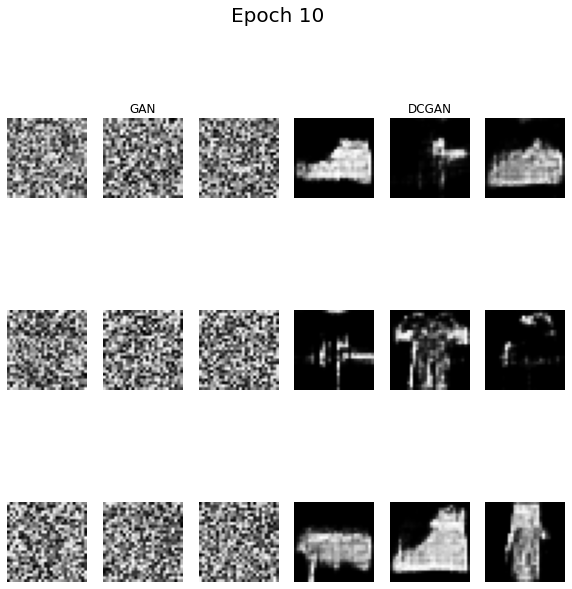

In [ ]:
visualize_9_generated_images(history_gan[0], history_dcgan[0], 'Epoch 10', 'GAN', 'DCGAN')   

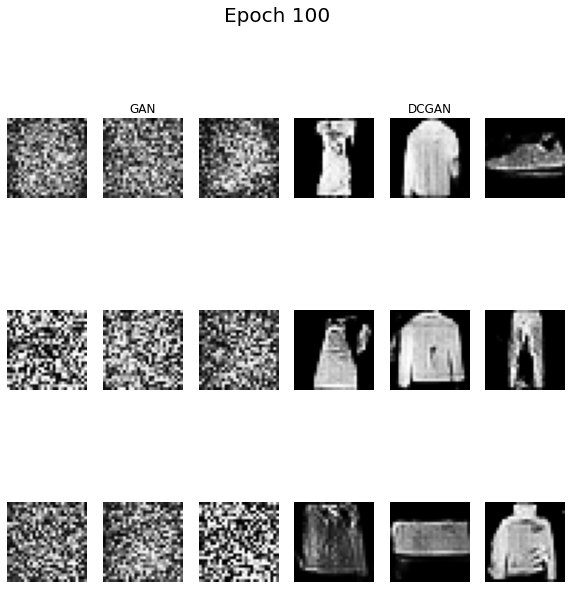

In [ ]:
visualize_9_generated_images(history_gan[1], history_dcgan[1], 'Epoch 100', 'GAN', 'DCGAN')   

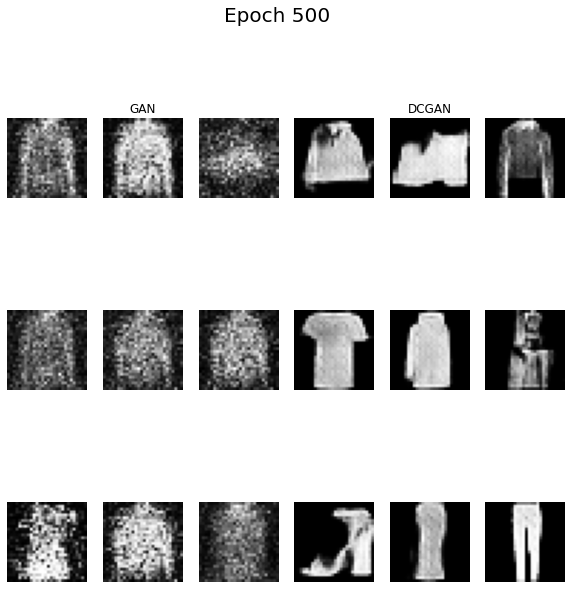

In [ ]:
visualize_9_generated_images(history_gan[2], history_dcgan[2], 'Epoch 500', 'GAN', 'DCGAN')   

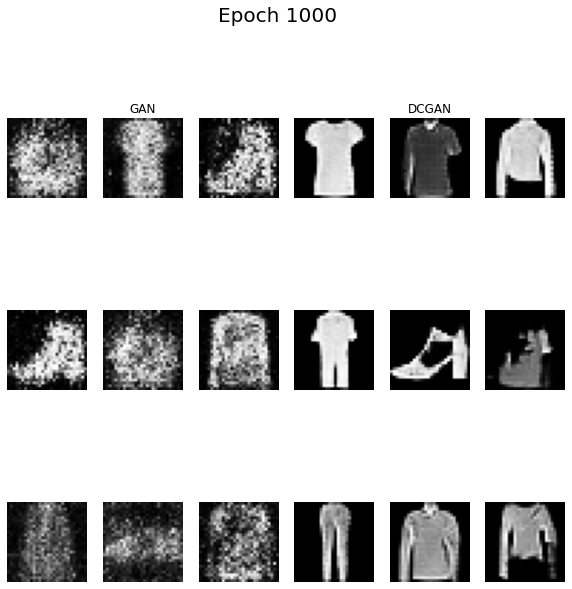

In [ ]:
visualize_9_generated_images(history_gan[3], history_dcgan[3], 'Epoch 1000', 'GAN', 'DCGAN')   

Como es lógico una estructura más compleja y convolusional como la DCGAN entrega mejores resultados donde la gran mayoría de las imagenes parecen reales a primera vista pero en detalle se puede observar poleras, polerones con brazos más cortos.

Por otro lado una estructura sencilla como la GAN que no es convolusional trata de generar imagenes pero solo logra pintas alrededor de un contorno de la imagen.

Además la DCGAN es capaz de crear imágenes realistas en las primera épocas mientras que una estructura más sencilla todavía no es capaz de aprender nada.

## Pregunta 2: Recurrent Neural Networks (RNN)

Imagine que llega a su nuevo trabajo, el cuál obtuvo luego de una muy buena entrevista en la que deleitó a su actual jefe con sus conocimientos de Deep Learning. A su sorpresa, llega uno de sus colegas y le comienza a decir que estan trabajando en un sistema de pronósticos del precio de acciones transadas en la Bolsa de Santiago, pero que hasta el momento no han podido utilizar algo mas complejo que un MLP. Le explican que ellos sólo desfasan los valores de apertura de las acciones por unos cuantos días (usted vió su código y son 5 días exáctamente), tratando de imitar el concepto de autocorrelación propio de las series de tiempo. 

Como usted quiere demostrar su valía como nueva contratación les pide que le pasen información histórica de cuatro acciones: Enel Americas, Copec, CMPC, y Engie Energía. También les dice que usted generará un modelo integrado que recibe información histórica de las 4 series y predice al mismo tiempo los 4 valores para el día siguiente. Además, como su emoción es tan grande, se compromete en comparar sus resultados con el modelo que ellos tienen implementado. 

Adicionalmente, ellos le comentan que les interesaría que los modelo sean entrenado en los que terminan el 12/29/2017, y que el set de testeo comience el día inmediatamente siguiente. Además, usted recuerda que k-fold Cross Validation no funciona para las series de tiempo, por lo que debe utilizar Walk-Forward validation para entrenar su modelo y elegir los mejores hiper-parámetros. Finalmente, le enviaron un correo que contiene el archivo aquiVanLosDatosCompadre.zip

Puntaje:
1. Implementación, selección de hyperparámetros, y entrenamiento del MLP (5 ptos).
2. Implementación, selección de hyperparámetros, y entrenamiento del LSTM RNN (10 ptos).
3. Evaluación de métricas de desempeño durante el pediodo de testeo y comparación del rendimiento de ambos modelos (5 ptos).

In [ ]:
#####FUNCIONES AUXILIARES PREGUNTA 2  #######

#visualizar data
#visualizar TODOS LOS DATOS
def visualize_socks_prices_all(train, test):
  company = train.columns.tolist()
  company_colors = ['blue', 'green', 'yellow', 'red']
  fig = plt.figure(figsize = ((10,7)))
  i = 0
  for name in company:
    plt.plot(train.index.to_numpy(), train[name].to_numpy(), label = name , color=company_colors[i])  #train
    plt.plot(test.index.to_numpy(), test.loc['2017-12-22':,name].to_numpy(), color =company_colors[i])  #test DESDE la fecha 5 en adelante '2017-12-22'
    plt.xticks(['2009-01-02', '2017-12-29', '2020-05-29'])
    i+=1
  plt.legend()
  plt.title('Stocks Prices', fontsize = 25)
  plt.xlabel('Time', fontsize = 15)
  plt.ylabel('Stock price', fontsize = 15)
  fig.tight_layout()
  plt.show()

#visualizar datos TRAIN y TEST a traves de los df finales 
def visualize_stocks_prices_individual(train, test):
  company = train.columns.tolist()
  fig, axs = plt.subplots(4, 1, figsize = ((20,15)))
  i = 0
  for name in company:
    axs[i].plot(train.index.to_numpy(), train[name].to_numpy(), label = 'Train', color='Black')  #train
    axs[i].plot(test.index.to_numpy(), test.loc['2017-12-22':,name].to_numpy(), label = 'Test', color = 'Orange')  #test DESDE '2017-12-22'
    axs[i].set_xticks(['2009-01-02', '2017-12-29', '2020-05-29'])
    axs[i].set_title(name, fontsize = 25)
    axs[i].legend()
    axs[i].set_xlabel('Time', fontsize = 15)
    axs[i].set_ylabel('Stock price', fontsize = 15)
    i+=1
  fig.tight_layout()
  plt.show()

#nornalizar y crear serie temporal
# 1) normalizar
from sklearn.preprocessing import MinMaxScaler
def normalize_stocks_prices(train, test):
  minmax = MinMaxScaler()
  train_scaled = minmax.fit_transform(train)
  test_scaled = minmax.transform(test)    
  return minmax, train_scaled, test_scaled

# 2) Crear data serie de tiempo
def create_1_feature_data_time(data_scaled, time_step):
  '''
  Transformar datos de serie de tiempo al tipo acorde para red neuronal
  3D array with samples, timestamps, and features(stock prices).
  
  OBS: En la pregunta del problema dice que desfasan 5 dias, asumo que son 5 datos porque la información 
  reportada de las acciones no son de frecuencia diaria
  '''
  #funciona para una columna
  X = []
  y = []
  for i in range(time_step, data_scaled.shape[0]):
    X.append(data_scaled[i-time_step:i, 0])
    y.append(data_scaled[i, 0])
  X, y = np.array(X), np.array(y)
  X = np.reshape(X, (X.shape[0], X.shape[1], 1))
  y = np.reshape(y, (y.shape[0], 1))
  return X, y

def create_data_time(data_complete_scaled, time_window = 5):
  for i in range(data_complete_scaled.shape[1]):  #para cada una de las empresas
    if i == 0:
      X, y = create_1_feature_data_time(data_complete_scaled[:, i].reshape(data_complete_scaled.shape[0], 1),  time_window  )
      X_features = X.copy()
      y_features = y.copy()
    else:
      X, y = create_1_feature_data_time(data_complete_scaled[:, i].reshape(data_complete_scaled.shape[0], 1),  time_window  )
      X_features = np.dstack((X_features,X))   #apilar en la tercera dimension (batch, ventana, features)
      y_features = np.hstack((y_features,y))   #apilar en la segunda dimension (batch, label)
  return X_features, y_features

#MODELOS
#callback, usar early stopping en ambos modelos
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=10,
                                                    mode='min',
                                                  restore_best_weights = True)

def visualize_predictions_all(data_real, data_pred):
  list_comp = ['Adj_Close_CMPC', 'Adj_Close_COPEC', 'Adj_Close_ECL', 'Adj_Close_ENELAM']
  list_color = ['blue', 'green', 'yellow', 'red']
  fig = plt.figure(figsize = ((10,7)))
  x_space = np.linspace(1, len(data_real), len(data_real))
  i = 0
  for name in list_comp:
    plt.plot(data_real[:, i], linestyle = '-', label = 'real'+name, color = list_color[i], alpha = 0.2, lw = 3)
    plt.scatter(x_space, data_pred[:, i], marker = 'x', alpha = 0.5, label = 'prediction'+name, color=list_color[i])
    i +=1
  
  plt.legend()
  plt.grid(color = 'black', alpha = 0.5, linestyle = 'dashed', linewidth = 0.5)
  plt.xticks([])
  plt.xlabel('Time', fontsize = 13)
  plt.ylabel('Stock price', fontsize = 13)
  plt.title('Test: Real vs Predict', fontsize = 15)

def visualize_loss_model(loss_train, loss_valid, tittle, both = False, loss_train_2 = None, loss_valid_2 = None):
  if both==False:
    plt.plot(loss_train, color='gray', label = 'loss_train', linestyle = '-')
    plt.plot(loss_valid, color = 'purple', label = 'loss_test')
  if both ==True:
    fig = plt.figure(figsize=((8,8)))
    plt.plot(loss_train, color='gray', label = 'loss_train_mlp', linestyle = '-')
    plt.plot(loss_valid, color = 'purple', label = 'loss_test_mlp')
    plt.plot(loss_train_2, color= 'blue', label = 'loss_train_rnn', linestyle = '-')
    plt.plot(loss_valid_2, color = 'pink', label = 'loss_test_rnn') 
  
  plt.title(tittle, fontsize = 18)
  plt.grid(color = 'black', alpha = 0.5, linestyle = 'dashed', linewidth = 0.5)
  plt.xlabel('Epochs', fontsize = 13)
  plt.legend()

def visualize_predictions_individual(data_real, data_pred, name, both= False, data_pred_2 = None):
  fig = plt.figure(figsize = ((10,7)))
  x_space = np.linspace(1, len(data_real), len(data_real))
  if both == False:
    plt.plot(data_real, linestyle = '-', label = 'real')
    plt.scatter(x_space, data_pred, marker = 'x', color = 'red', alpha = 0.5, label = 'prediction')
  if both == True:
    plt.plot(data_real, linestyle = '-', label = 'real')
    plt.scatter(x_space, data_pred, marker = 'x', color = 'red', alpha = 0.5, label = 'prediction_mlp')
    plt.scatter(x_space, data_pred_2, marker = 'o', color = 'green', alpha = 0.5, label = 'prediction_rnn')

  plt.legend()
  plt.grid(color = 'black', alpha = 0.5, linestyle = 'dashed', linewidth = 0.5)
  plt.xlabel('Time', fontsize = 13)
  plt.ylabel('Stock price', fontsize = 13)
  plt.xticks([])
  plt.title('Test: Real vs Predict (' +name +')', fontsize = 15)

### Preprocess Data

In [ ]:
#data
!unrar x '/content/drive/My Drive/Certamen 2 MLBI/Data C2.rar' 
!ls '/content/Data C2/'  #nombre de los archivos CMPC.csv  COPEC.csv  ECL.csv  ENELAM.csv


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/My Drive/Certamen 2 MLBI/Data C2.rar


Would you like to replace the existing file Data C2/CMPC.csv
 76489 bytes, modified on 2020-08-20 18:33
with a new one
 76489 bytes, modified on 2020-08-20 18:33

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit a

Extracting  Data C2/CMPC.csv                                              14%  OK 
Extracting  Data C2/COPEC.csv                                             69%  OK 
Extracting  Data C2/ECL.csv                                               82%  OK 
Extracting  Data C2/ENELAM.csv                                            99%  OK 
All OK
CMPC.csv  COPEC.csv  ECL.csv  ENELAM.csv


In [ ]:
CMPC_path = '/content/Data C2/CMPC.csv'
COPEC_path = '/content/Data C2/COPEC.csv'
ECL_path = '/content/Data C2/ECL.csv'
ENELAM_path = '/content/Data C2/ENELAM.csv'

In [ ]:
print('Example CMPC Data')
CMPC = pd.read_csv(CMPC_path, names = ['Date', 'Adj_Close'])
CMPC.head(3)   

Example CMPC Data


,Date,Adj_Close
0,2009-01-02,835.809998
1,2009-01-05,894.817017
2,2009-01-06,869.492004


In [ ]:
print('Example COPEC Data')
COPEC = pd.read_csv(COPEC_path)
COPEC.head(3)    
#The adjusted closing price amends a stock's closing price to reflect that stock's value after accounting for any corporate actions. 
#It is often used when examining historical returns or doing a detailed analysis of past performance.

Example COPEC Data


,Date,High,Low,Open,Close,Volume,Adj Close
0,2009-01-02,5190.0,4805.000000,4850.000000,5091.200195,5408482.0,4678.071289
1,2009-01-05,5150.0,4748.299805,4748.299805,5149.000000,748469.0,4731.181641
2,2009-01-06,5350.0,5149.000000,5149.000000,5337.100098,331189.0,4904.017090


In [ ]:
print('Example COPEC Data with Adj_Close')
COPEC.drop(labels = ['High','Low', 'Open', 'Close', 'Volume'], axis = 1, inplace =  True)
COPEC.rename(columns={"Adj Close": "Adj_Close"}, inplace = True)
COPEC.head(3)

Example COPEC Data with Adj_Close


,Date,Adj_Close
0,2009-01-02,4678.071289
1,2009-01-05,4731.181641
2,2009-01-06,4904.017090


In [ ]:
print('Example ECL Data')
ECL = pd.read_csv(ECL_path,names = ['Date', 'Adj_Close'] )
ECL.head(3) 

Example ECL Data


,Date,Adj_Close
0,2009-01-02,486.000000
1,2009-01-05,469.890015
2,2009-01-06,490.000000


In [ ]:
print('Example ENELAM Data')
ENELAM = pd.read_csv(ENELAM_path,names = ['Date', 'Adj_Close'])
ENELAM.head(3) 

Example ENELAM Data


,Date,Adj_Close
0,2009-01-02,97.938004
1,2009-01-05,97.873199
2,2009-01-06,97.932098


In [ ]:
print('Extension data')
print( 'CMPC: ' ,len(CMPC))
print( 'COPEC: ' ,len(COPEC))
print( 'ECL: ' ,len(ECL))
print( 'ENELAM: ' ,len(ENELAM))

Extension data
CMPC:  2843
COPEC:  2843
ECL:  2843
ENELAM:  2843


In [ ]:
print('Join Data')
data = pd.merge(  pd.merge(   pd.merge(CMPC,COPEC, on = 'Date', suffixes = ('_CMPC', '_COPEC') ),   
                           ECL , on = 'Date', suffixes = ('', '_ECL') ) ,  
                            ENELAM , on = 'Date', suffixes = ('', '_ENELAM')) 
data.rename( columns={data.columns[1]: "Adj_Close_CMPC",
                      data.columns[2]: "Adj_Close_COPEC",
                      data.columns[3]: "Adj_Close_ECL",
                      data.columns[4]: "Adj_Close_ENELAM"}, inplace = True)
data.head(4)

Join Data


,Date,Adj_Close_CMPC,Adj_Close_COPEC,Adj_Close_ECL,Adj_Close_ENELAM
0,2009-01-02,835.809998,4678.071289,486.000000,97.938004
1,2009-01-05,894.817017,4731.181641,469.890015,97.873199
2,2009-01-06,869.492004,4904.017090,490.000000,97.932098
3,2009-01-07,958.130005,4777.030762,505.000000,97.932098


In [ ]:
#Crear data TRAIN Y TEST
#Seleccionar donde cortar la base de datos
indice_corte = data[data['Date'] =='2017-12-29'].index.to_numpy() #valor del índice del ultimo numero de train
indice_corte +=1  #valor indice donde parto en test
indice_corte -= 5
#fecha desde donde partir el conjunto de test, para que al predecir la primera fecha predicha sea la que viene despues del 12/29/2017
#data.loc[indice_corte, 'Date']     #output 2017-12-22 

#Crear Data Train y Test
data_train = data[data['Date'] <= '2017-12-29']
data_test = data[data['Date'] >= '2017-12-22']
data_train_final = data_train.set_index('Date')
data_test_final = data_test.set_index('Date')

### Visualize Data

Stocks prices all companies


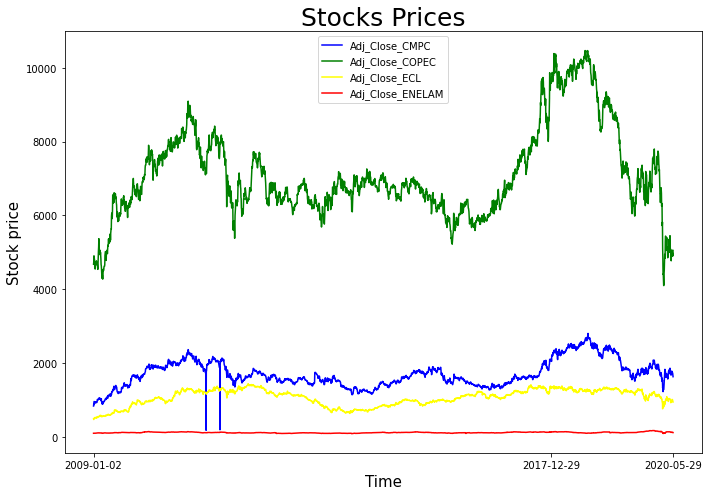

In [ ]:
print('Stocks prices all companies')
visualize_socks_prices_all(data_train_final, data_test_final)

Data TRAIN y TEST each company


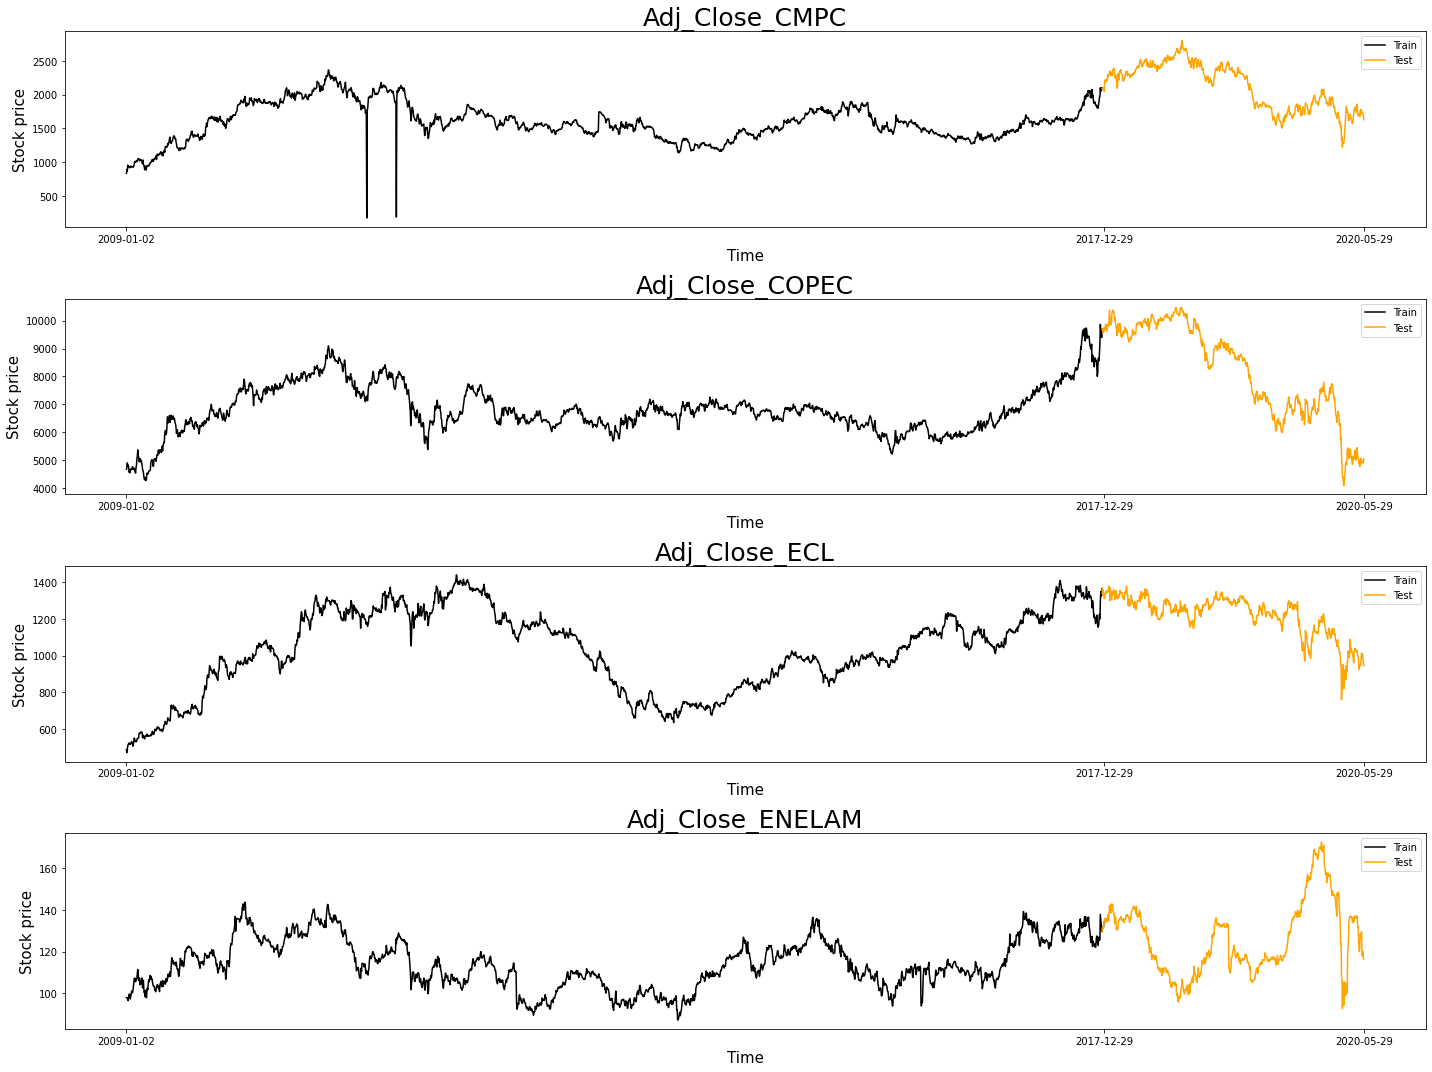

In [ ]:
print('Data TRAIN y TEST each company')
visualize_stocks_prices_individual(data_train_final, data_test_final)

### Preprocess Data 2: Normalize and Temporal Serie

In [ ]:
minmax, data_train_final_scaled, data_test_final_scaled = normalize_stocks_prices(data_train_final, data_test_final)
print('Normalize Data')
print('Min value Train: ', data_train_final_scaled.min())
print('Max value Train: ', data_train_final_scaled.max())

print('Min value Test: ', data_test_final_scaled.min())
print('Max value Test: ', data_test_final_scaled.max())

Normalize Data
Min value Train:  0.0
Max value Train:  1.0000000000000002
Min value Test:  -0.030892885918701762
Max value Test:  1.5102041479545258


In [ ]:
X_train, y_train = create_data_time(data_train_final_scaled, 5)
X_test, y_test = create_data_time(data_test_final_scaled, 5)
print('Dimensions Time Serie - Stocks Price')
print('\nDimension X_train',X_train.shape )
print('Dimension y_train',y_train.shape )
print('\nDimension X_test',X_test.shape )
print('Dimension y_test',y_test.shape )
print('Al sumar los datos da un total de 5 menos porque esos se usan para predecir el primer output y no pueden predecir otro valor')

Dimensions Time Serie - Stocks Price

Dimension X_train (2241, 5, 4)
Dimension y_train (2241, 4)

Dimension X_test (597, 5, 4)
Dimension y_test (597, 4)
Al sumar los datos da un total de 5 menos porque esos se usan para predecir el primer output y no pueden predecir otro valor


In [ ]:
print('EXAMPLES')
print('First batch Train, 5 values, 4 companies\n',X_train[0, :,:])
print('\nSecond batch Train, 5 values, 4 companies\n', X_train[1, :,:])
print('\nFirst batch Test, 1 value next period, 4 companies\n', y_train[0, :] )

EXAMPLES
First batch Train, 5 values, 4 companies
 [[0.30092687 0.07251574 0.01658754 0.18864627]
 [0.32792556 0.08201586 0.         0.18749612]
 [0.31633809 0.1129318  0.02070612 0.18854147]
 [0.35689445 0.09021712 0.03615077 0.18854147]
 [0.35110048 0.09861621 0.0464472  0.16341369]]

Second batch Train, 5 values, 4 companies
 [[0.32792556 0.08201586 0.         0.18749612]
 [0.31633809 0.1129318  0.02070612 0.18854147]
 [0.35689445 0.09021712 0.03615077 0.18854147]
 [0.35110048 0.09861621 0.0464472  0.16341369]
 [0.34801065 0.08837684 0.04953613 0.19901291]]

First batch Test, 1 value next period, 4 companies
 [0.34801065 0.08837684 0.04953613 0.19901291]


### MLP model

In [ ]:
#hiperparametros MLP
batch_size_mlp = 32
epochs_mlp = 100

In [ ]:
def create_MLP_stock_price(input_shape):
    #idea extract from: https://www.tensorflow.org/tutorials/structured_data/time_series#multi-step_dense
    model = Sequential()

    #flatten layer
    model.add(Input(shape = X_train.shape[1:]))
    model.add(Flatten())

    #FC 
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.2))

    #FC
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.2))

    #output 4 companies
    model.add(Dense(units=4))    
    return model

In [ ]:
model_mlp = create_MLP_stock_price(X_train.shape[1:])
model_mlp.compile(optimizer='adam',loss='mse', metrics=[tf.metrics.MeanAbsoluteError()])  #compilar
model_mlp.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 20)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 32)                672       
_________________________________________________________________
dropout_60 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_61 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 4)                 132       
Total params: 1,860
Trainable params: 1,860
Non-trainable params: 0
___________________________________________________

In [ ]:
history_mlp = model_mlp.fit(
    X_train,
    y_train,
    batch_size = batch_size_mlp,
    verbose = 1,
    epochs = epochs_mlp,
    validation_data = (X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/100
71/71 [==============================] - 0s 3ms/step - loss: 0.1483 - mean_absolute_error: 0.2839 - val_loss: 0.0402 - val_mean_absolute_error: 0.1395
Epoch 2/100
71/71 [==============================] - 0s 2ms/step - loss: 0.0416 - mean_absolute_error: 0.1600 - val_loss: 0.0390 - val_mean_absolute_error: 0.1430
Epoch 3/100
71/71 [==============================] - 0s 2ms/step - loss: 0.0313 - mean_absolute_error: 0.1392 - val_loss: 0.0358 - val_mean_absolute_error: 0.1410
Epoch 4/100
71/71 [==============================] - 0s 2ms/step - loss: 0.0271 - mean_absolute_error: 0.1283 - val_loss: 0.0280 - val_mean_absolute_error: 0.1239
Epoch 5/100
71/71 [==============================] - 0s 2ms/step - loss: 0.0240 - mean_absolute_error: 0.1193 - val_loss: 0.0282 - val_mean_absolute_error: 0.1283
Epoch 6/100
71/71 [==============================] - 0s 2ms/step - loss: 0.0204 - mean_absolute_error: 0.1104 - val_loss: 0.0251 - val_mean_absolute_error: 0.1183
Epoch 7/100
71/71 [===

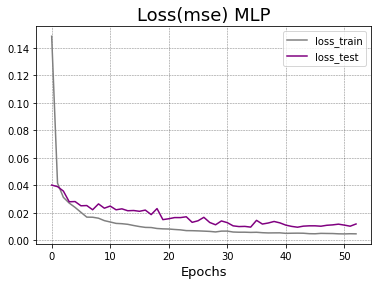

In [ ]:
mlp_loss = history_mlp.history['loss']
mlp_val_loss = history_mlp.history['val_loss']
visualize_loss_model(mlp_loss, mlp_val_loss, 'Loss(mse) MLP', False)

In [ ]:
#Predicctions
predict_test_mlp = model_mlp.predict(X_test)
predict_test_mlp = minmax.inverse_transform(predict_test_mlp)  #escala real de valores predichos
y_test_real = minmax.inverse_transform(y_test) #escala real de valores de TEST mismo para ambos modelos

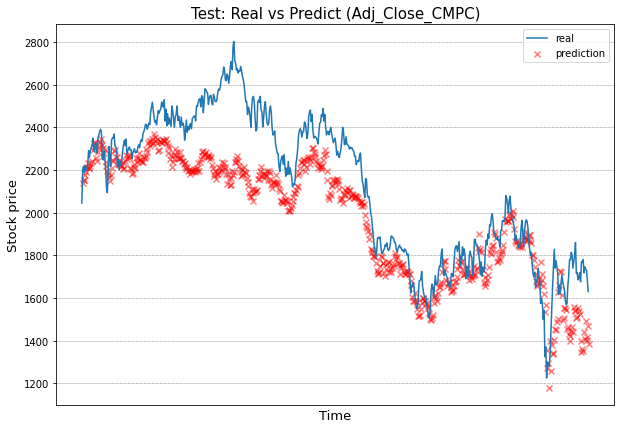

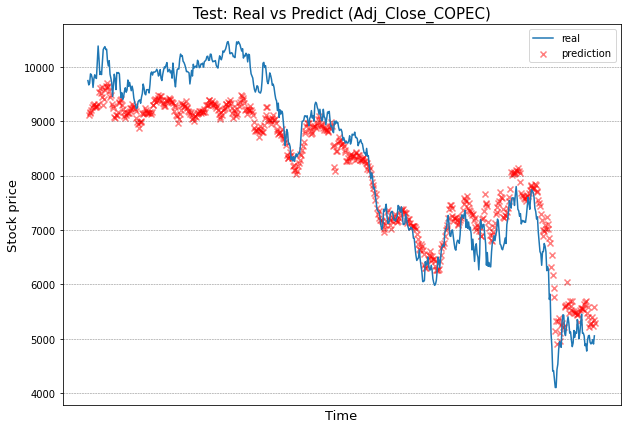

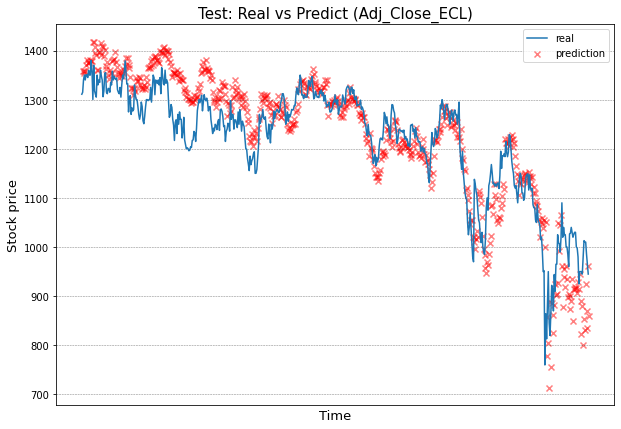

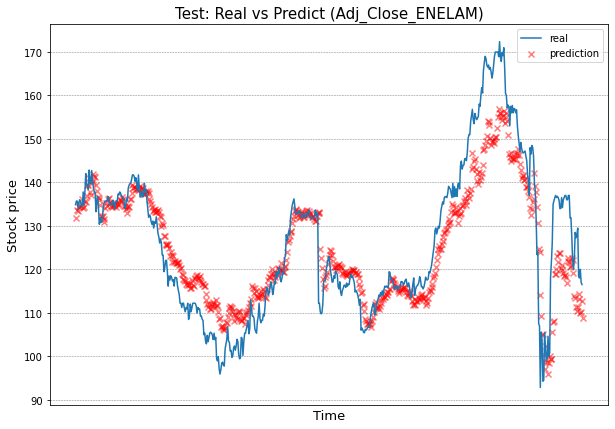

In [ ]:
list_companies = ['Adj_Close_CMPC', 'Adj_Close_COPEC', 'Adj_Close_ECL', 'Adj_Close_ENELAM']
i = 0
for name in list_companies:
  visualize_predictions_individual(y_test_real[:, i], predict_test_mlp[:, i], name, False)
  i+=1   

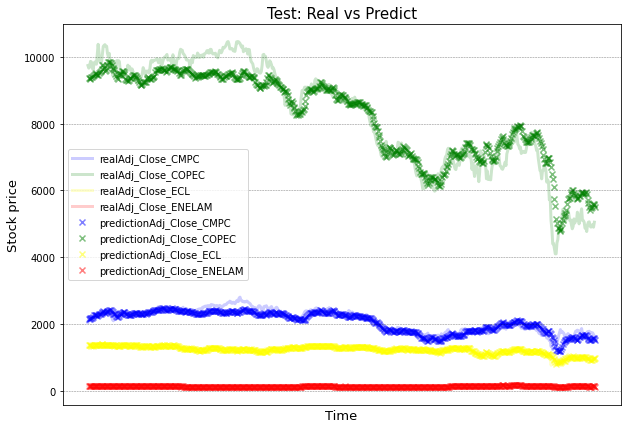

In [ ]:
visualize_predictions_all(y_test_real, predict_test_rnn)

### RNN model

In [ ]:
#hiperparametros rnn
batch_size_rnn = 32
epochs_rnn = 100

In [ ]:
def create_LSTM_RNN_stock_price(input_shape):
  #model by: https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233

  model = Sequential()
  #first LSTM
  model.add(LSTM(units=50,return_sequences=True,input_shape= input_shape   ))
  model.add(Dropout(0.2))
  #second LSTM
  model.add(LSTM(units=50,return_sequences=True))
  model.add(Dropout(0.2))

  #third LSTM
  model.add(LSTM(units=50,return_sequences=True))
  model.add(Dropout(0.2))

  #fourth LSTM
  model.add(LSTM(units=50))
  model.add(Dropout(0.2))

  #Output 
  model.add(Dense(units=4))    #4 empresas
  return model

In [ ]:
model_rnn = create_LSTM_RNN_stock_price(X_train.shape[1:])  #crear modelo con el tamaño del X_train
model_rnn.compile(optimizer='adam',loss='mse', metrics=[tf.metrics.MeanAbsoluteError()])  #compilar
model_rnn.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 5, 50)             11000     
_________________________________________________________________
dropout_62 (Dropout)         (None, 5, 50)             0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 5, 50)             20200     
_________________________________________________________________
dropout_63 (Dropout)         (None, 5, 50)             0         
_________________________________________________________________
lstm_43 (LSTM)               (None, 5, 50)             20200     
_________________________________________________________________
dropout_64 (Dropout)         (None, 5, 50)             0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 50)              

In [ ]:
history_rnn = model_rnn.fit(
    X_train,
    y_train,
    batch_size = batch_size_rnn,
    verbose = 1,
    epochs = epochs_rnn,
    validation_data = (X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/100
71/71 [==============================] - 4s 50ms/step - loss: 0.0747 - mean_absolute_error: 0.2023 - val_loss: 0.0516 - val_mean_absolute_error: 0.1768
Epoch 2/100
71/71 [==============================] - 1s 14ms/step - loss: 0.0183 - mean_absolute_error: 0.1082 - val_loss: 0.0405 - val_mean_absolute_error: 0.1559
Epoch 3/100
71/71 [==============================] - 1s 14ms/step - loss: 0.0146 - mean_absolute_error: 0.0967 - val_loss: 0.0286 - val_mean_absolute_error: 0.1325
Epoch 4/100
71/71 [==============================] - 1s 14ms/step - loss: 0.0100 - mean_absolute_error: 0.0791 - val_loss: 0.0323 - val_mean_absolute_error: 0.1435
Epoch 5/100
71/71 [==============================] - 1s 14ms/step - loss: 0.0092 - mean_absolute_error: 0.0757 - val_loss: 0.0351 - val_mean_absolute_error: 0.1428
Epoch 6/100
71/71 [==============================] - 1s 14ms/step - loss: 0.0085 - mean_absolute_error: 0.0721 - val_loss: 0.0199 - val_mean_absolute_error: 0.1040
Epoch 7/100
71/7

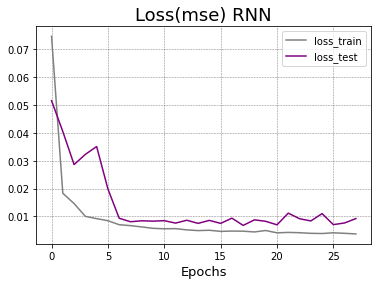

In [ ]:
rnn_loss = history_rnn.history['loss']
rnn_val_loss = history_rnn.history['val_loss']
visualize_loss_model(rnn_loss, rnn_val_loss, 'Loss(mse) RNN', False)

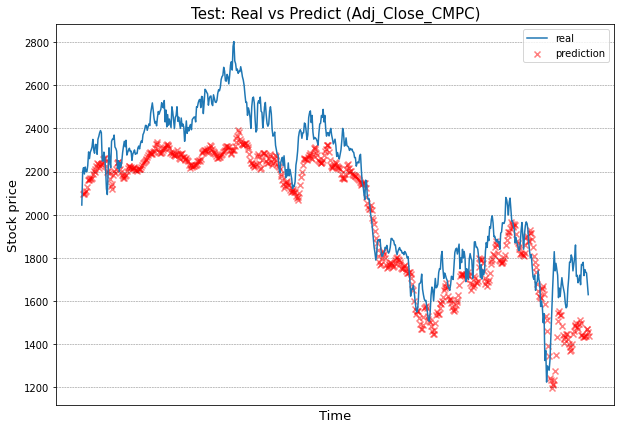

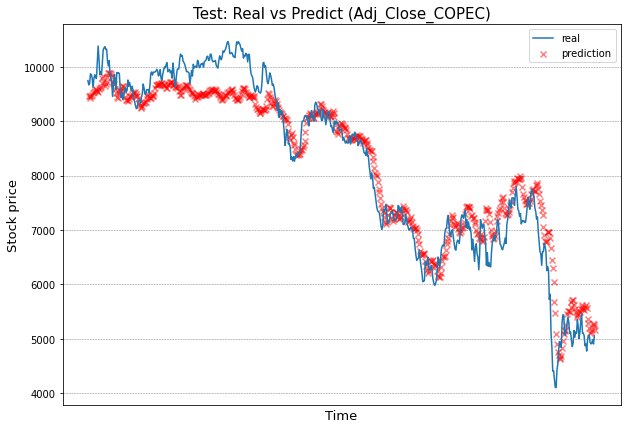

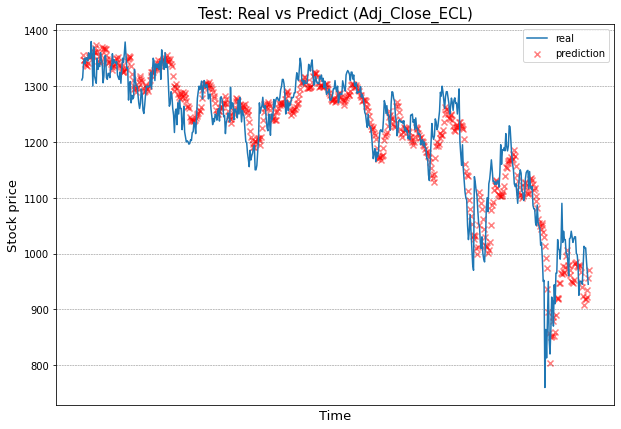

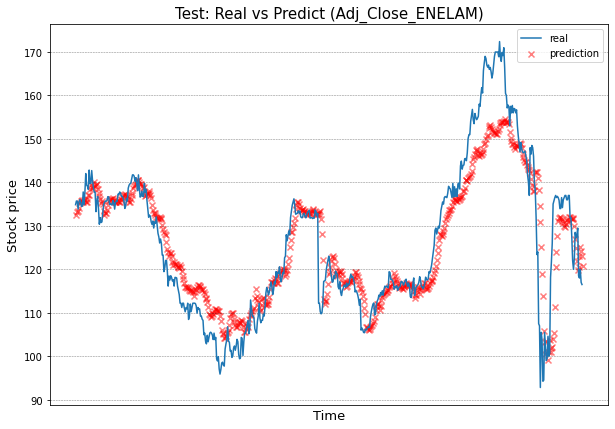

In [ ]:
#Predicctions
predict_test_rnn = model_rnn.predict(X_test)
predict_test_rnn = minmax.inverse_transform(predict_test_rnn)  #escala real de valores predichos RNN
y_test_real = minmax.inverse_transform(y_test) #escala real de valores de TEST

list_companies = ['Adj_Close_CMPC', 'Adj_Close_COPEC', 'Adj_Close_ECL', 'Adj_Close_ENELAM']
i = 0
for name in list_companies:
  visualize_predictions_individual(y_test_real[:, i], predict_test_rnn[:, i], name, False)
  i+=1  

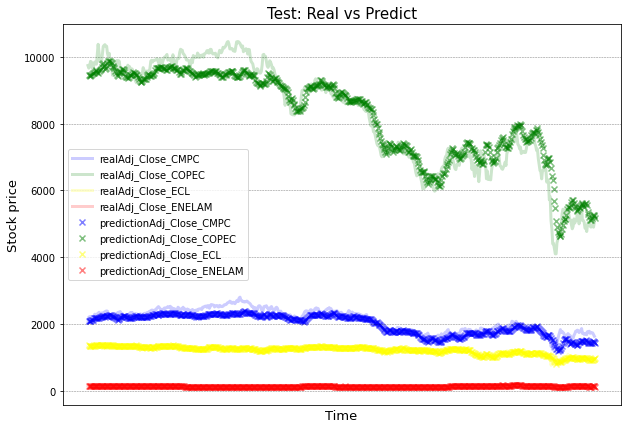

In [ ]:
visualize_predictions_all(y_test_real, predict_test_rnn)

### Differences between models

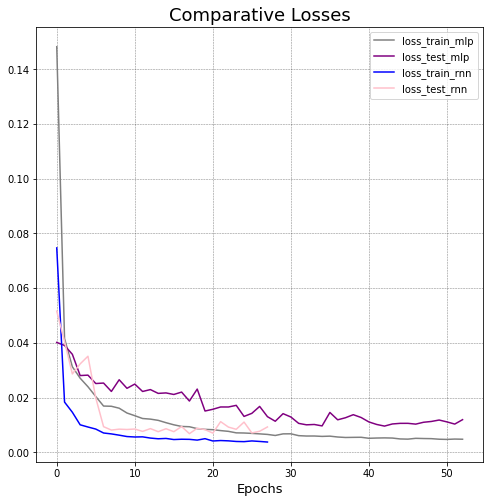

In [ ]:
visualize_loss_model(mlp_loss, mlp_val_loss, 'Comparative Losses', True, rnn_loss, rnn_val_loss)

Se puede observar que la loss en el modelo RNN es más baja, lo que significa que este modelo se predice valores de las acciones que son más parecidas a los valores reales

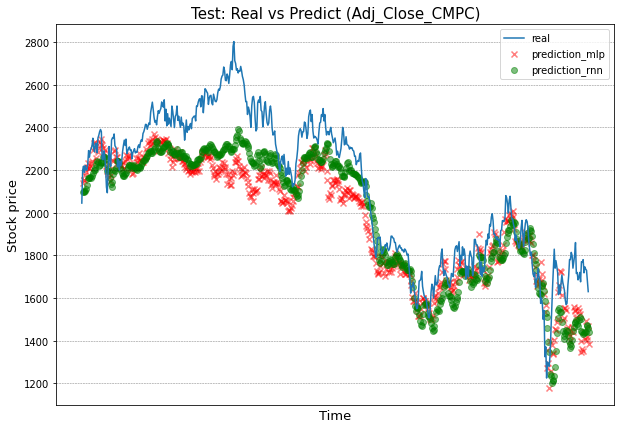

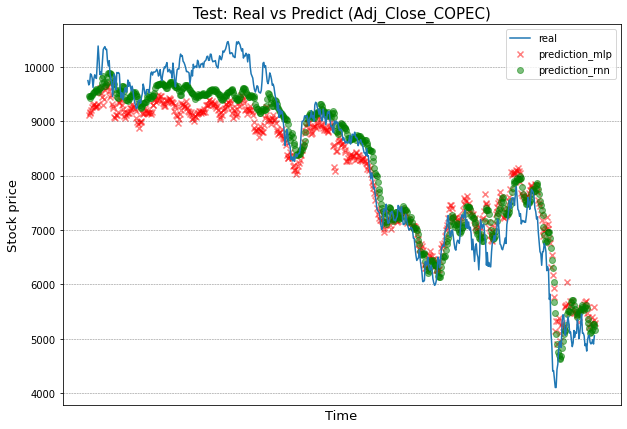

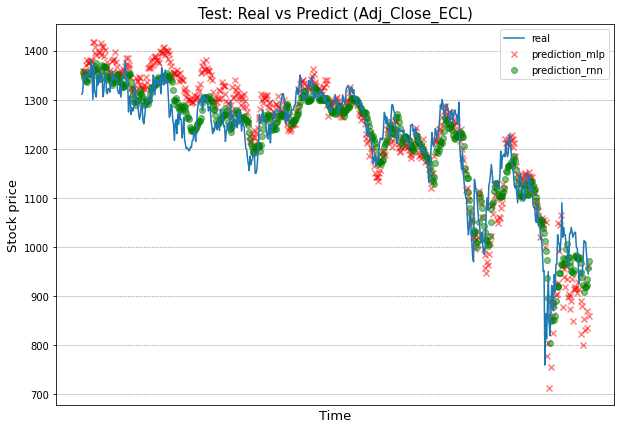

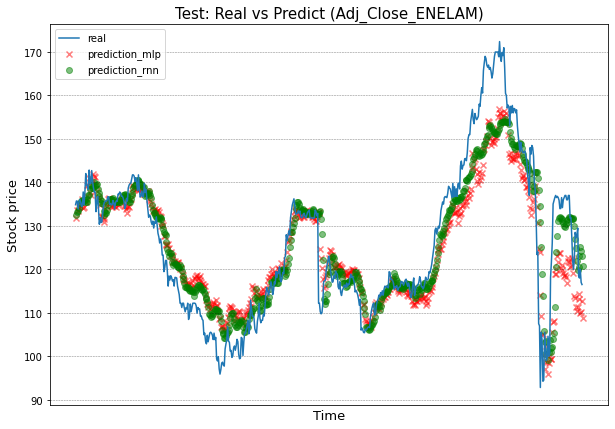

In [ ]:
list_companies = ['Adj_Close_CMPC', 'Adj_Close_COPEC', 'Adj_Close_ECL', 'Adj_Close_ENELAM']
i = 0
for name in list_companies:
  visualize_predictions_individual(y_test_real[:, i], predict_test_mlp[:, i], name, True, predict_test_rnn[:, i] )
  i+=1  

De forma gráfica se puede observar que los valores predichos por el modelo RNN se ajusta de mejor forma al predecir valores (puntos verdes) más cercanos a los reales (línea azul) para los valores de las acciones de todas las firmas, excepto para ECL que no se puede observar diferencias significativas en las predicciones realizadas por el modelo mlp y el modelo rnn.
Por lo tanto, es recomendable utilizar el modelo rnn que ofrece un mayor poder predictivo en comparación al modelo utilizado actualmente con la misma configuración de la base de datos.